# BCA Car Price Prediction by Jonathan Lampkin - EDA

## Overview
This notebook is used for Exploratory Data Analysis to understand the dataset.




## Install Packages


In [ ]:
# Install all dependencies from requirements files
%pip install -Uq pip
%pip install -r ../requirements-dev.txt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import re
from unidecode import unidecode

import os
os.makedirs("artifacts", exist_ok=True)



## Load Data


In [ ]:
df = pd.read_csv("../data/EUDS_CaseStudy_Pricing.csv")

# Quick info and validation
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18575 entries, 0 to 18574
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   vehicleID         18575 non-null  object
 1   registrationDate  18575 non-null  object
 2   kilometers        18575 non-null  int64 
 3   colour            18556 non-null  object
 4   aestheticGrade    18575 non-null  object
 5   mechanicalGrade   18575 non-null  object
 6   saleDate          18575 non-null  object
 7   make              18575 non-null  object
 8   model             18575 non-null  object
 9   doorNumber        18575 non-null  int64 
 10  type              18575 non-null  object
 11  fuel              18575 non-null  object
 12  transmission      18575 non-null  object
 13  yearIntroduced    18575 non-null  int64 
 14  cylinder          18575 non-null  int64 
 15  cubeCapacity      18575 non-null  int64 
 16  powerKW           18575 non-null  int64 
 17  powerHP     

In [ ]:
def clean_ascii(s):
    if pd.isna(s):
        return s
    s = unidecode(str(s))
    s = s.lower()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

cat_cols = df.select_dtypes(include=["object", "category"]).columns
if len(cat_cols) > 0:
    df[cat_cols] = df[cat_cols].applymap(clean_ascii)

/tmp/ipykernel_1146074/732260928.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cat_cols] = df[cat_cols].applymap(clean_ascii)


## YData Profiling 

In [ ]:
# report = ProfileReport(df, title="EDA Car Prices", explorative=True)

# # Save report to HTML
# html_path = "artifacts/eda_report.html"
# report.to_file(html_path)

# from IPython.display import HTML, display
# display(HTML(report.to_html()))



## Oldschool (Manual) EDA


In [ ]:
print(f"Duplicates: {df.duplicated().sum()}")


Duplicates: 0


## Missing Values Pattern Investigation


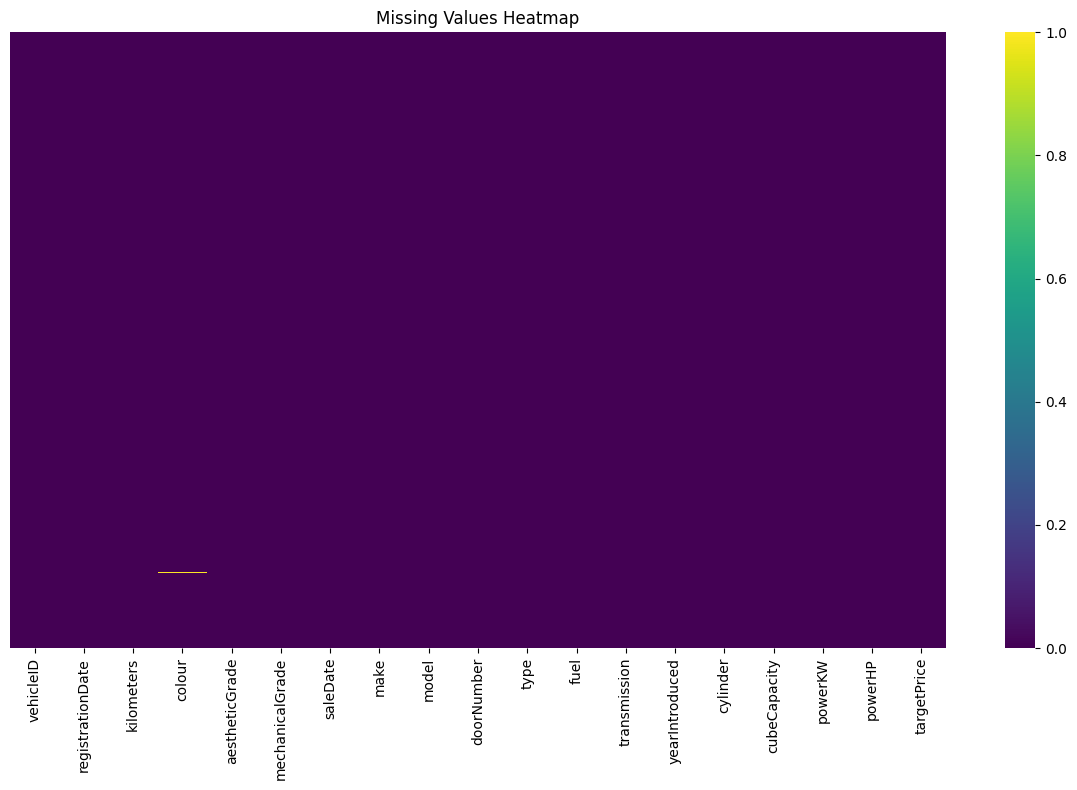

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.savefig('artifacts/missing_values_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()



## TargetPrice EDA


Skewness: 2.716
Kurtosis: 10.857


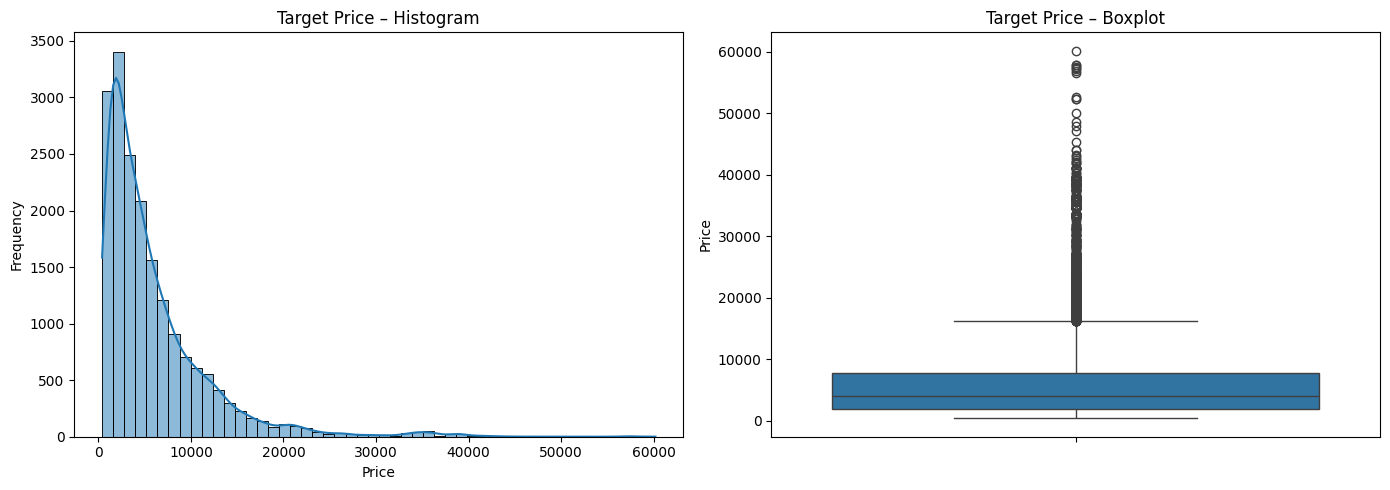

In [ ]:
y = df["targetPrice"].astype(float).dropna()
print(f"Skewness: {y.skew():.3f}")
print(f"Kurtosis: {y.kurtosis():.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Target Price – Histogram")
axes[0].set_xlabel("Price"); axes[0].set_ylabel("Frequency")

sns.boxplot(y=y, ax=axes[1], whis=1.5)
axes[1].set_title("Target Price – Boxplot")
axes[1].set_xlabel(""); axes[1].set_ylabel("Price")

plt.tight_layout()
plt.show()


## Histograms


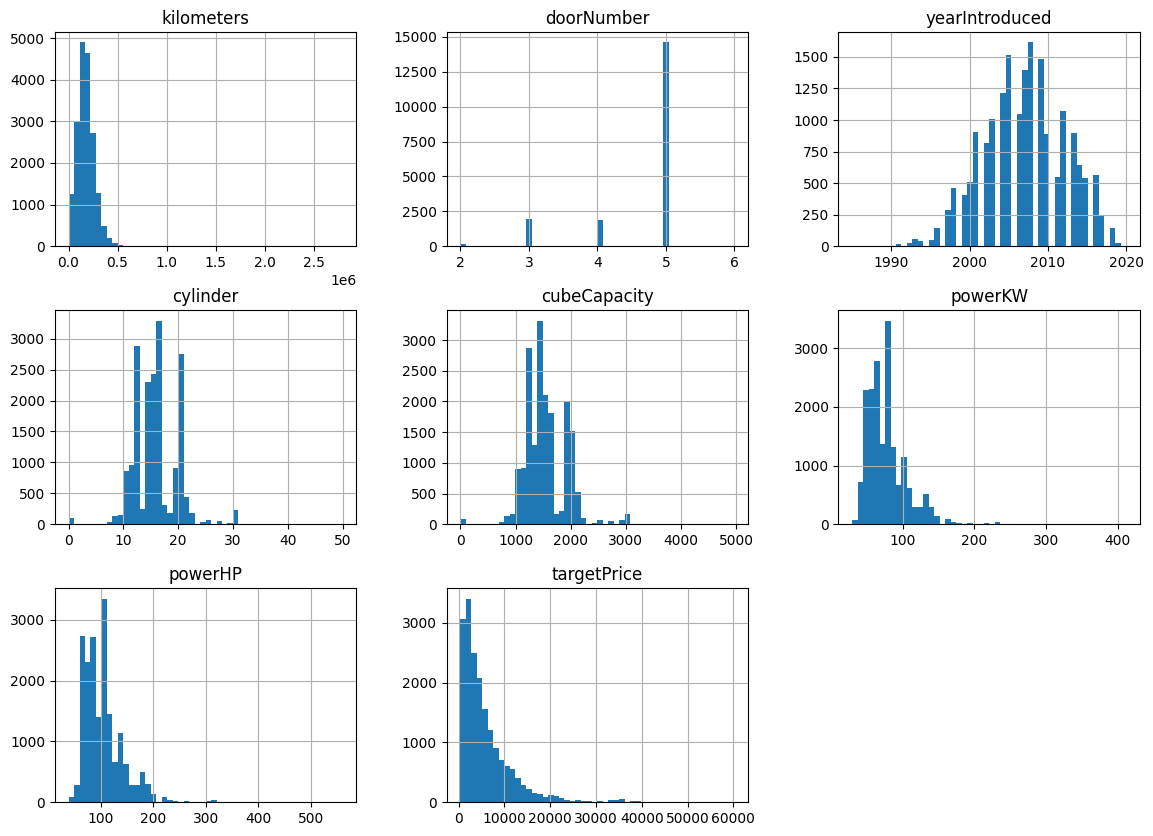

In [ ]:
num_cols = df.select_dtypes(include='number').columns
ax = df[num_cols].hist(figsize=(14, 10), bins=50)
# plt.tight_layout()
plt.show()


## Box Plots


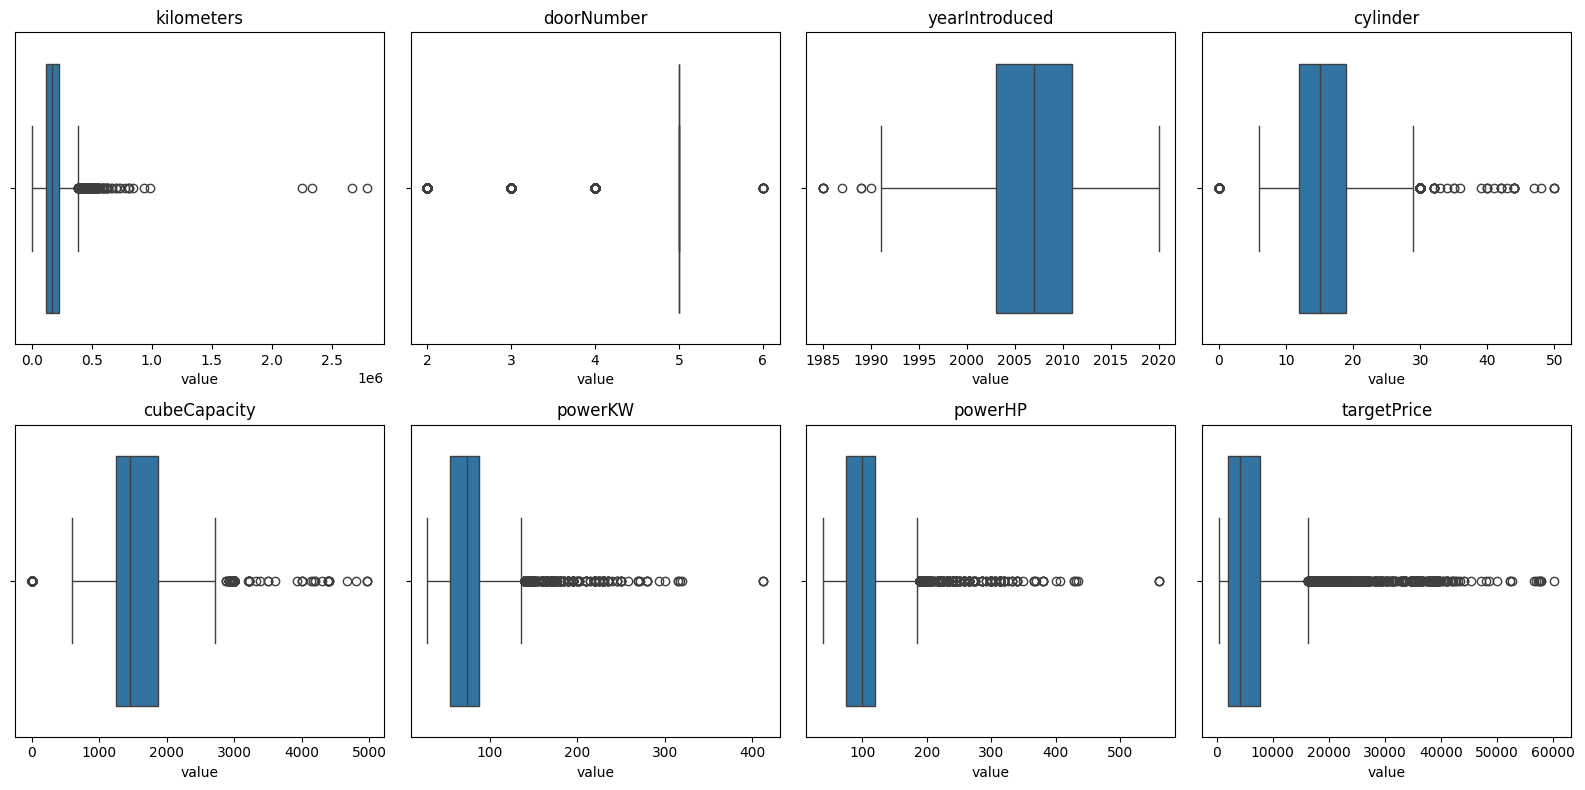

In [ ]:
um_cols = df.select_dtypes(include="number").columns
n = len(num_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
axes = axes.flatten()

for ax, c in zip(axes, num_cols):
    sns.boxplot(x=df[c], ax=ax, whis=1.5)
    ax.set_title(c)
    ax.set_xlabel("value")
    ax.set_ylabel("")

for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


## Correlation Analysis


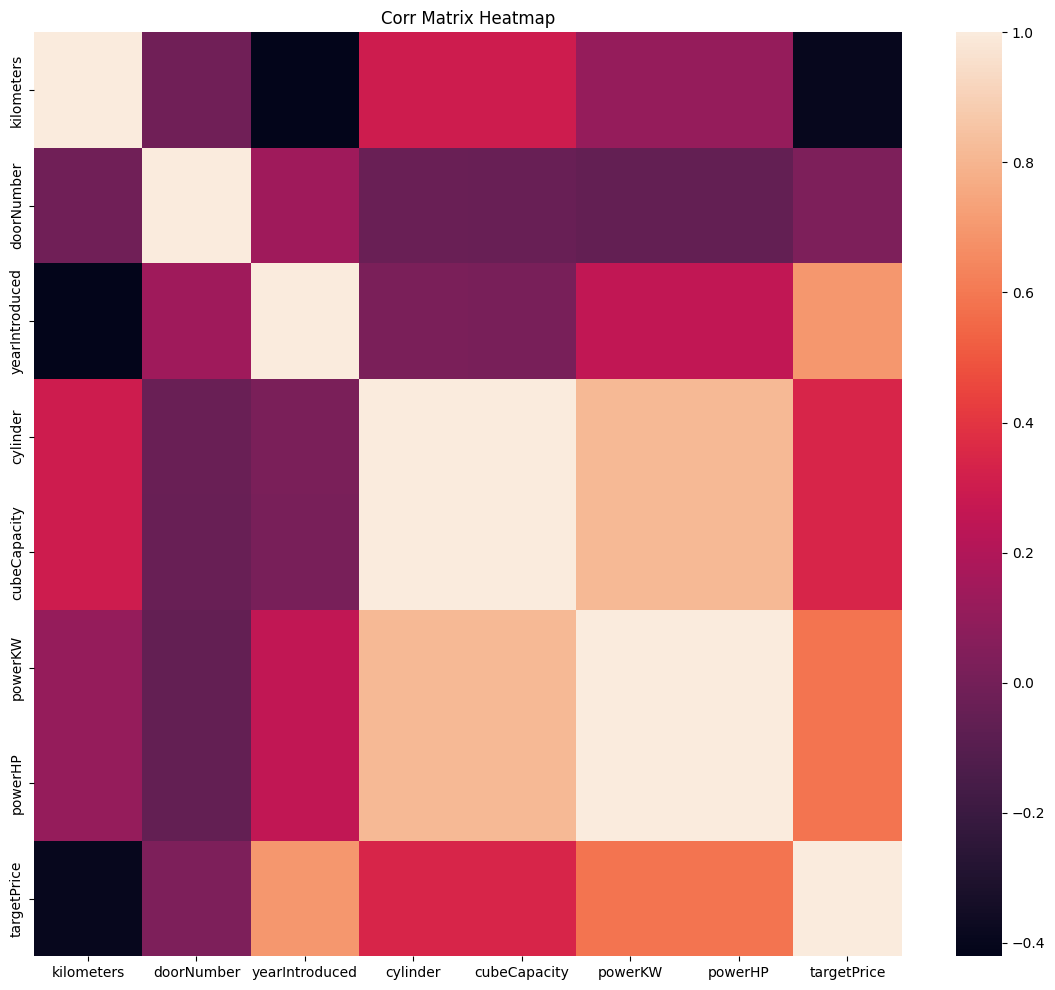

In [ ]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix)
plt.title('Corr Matrix Heatmap')
# plt.tight_layout()
# plt.savefig('artifacts/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Categorical Features Countplots


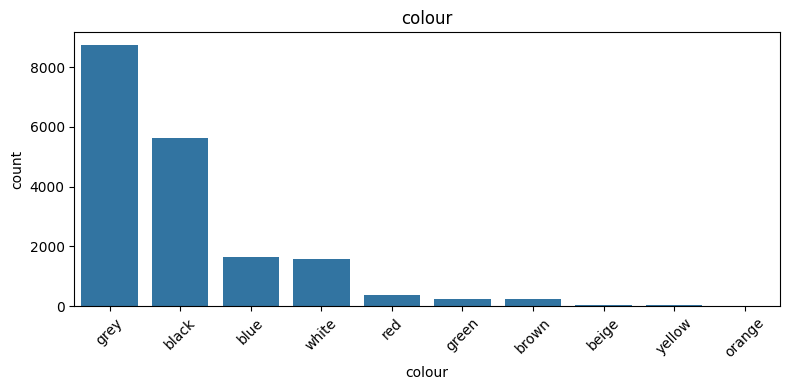

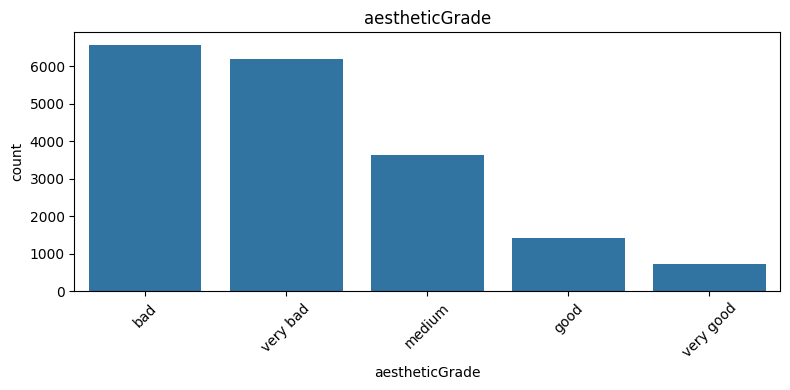

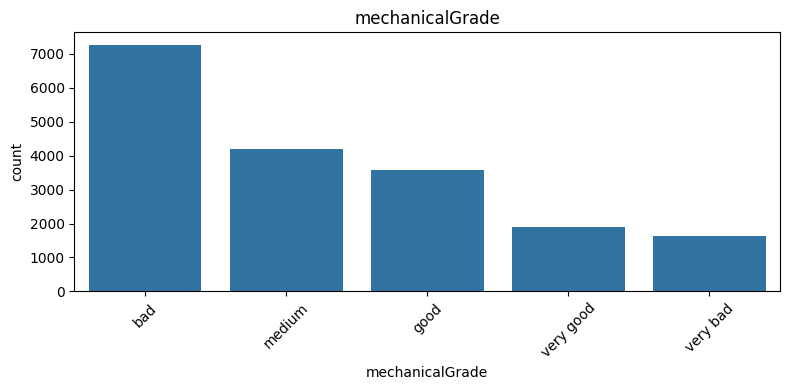

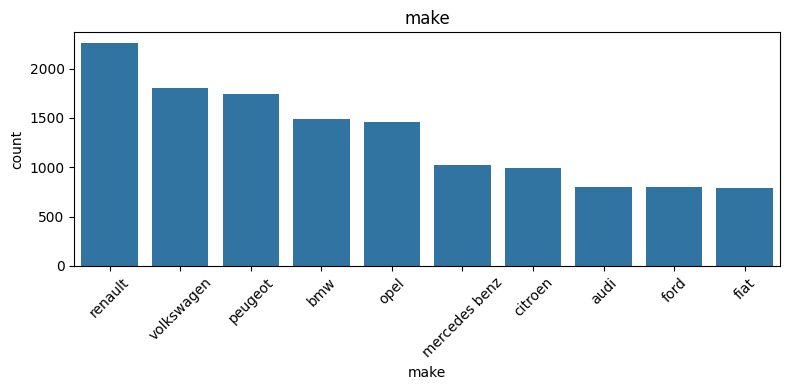

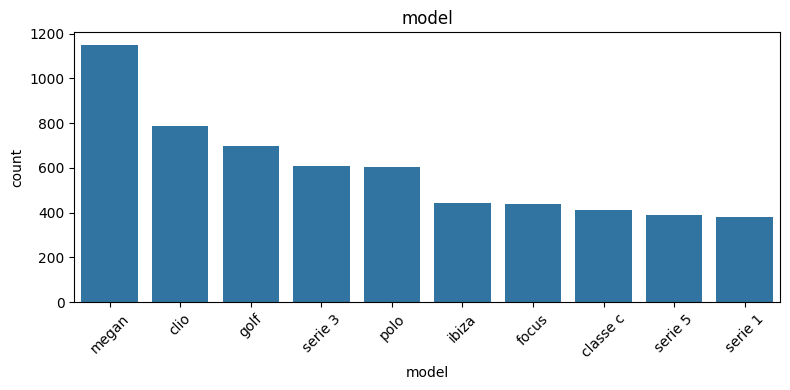

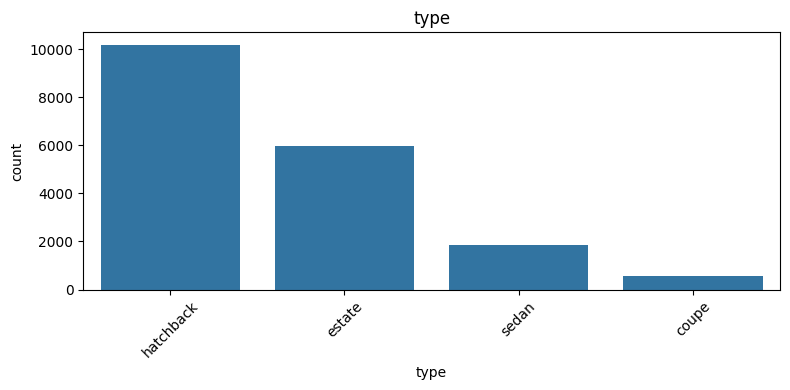

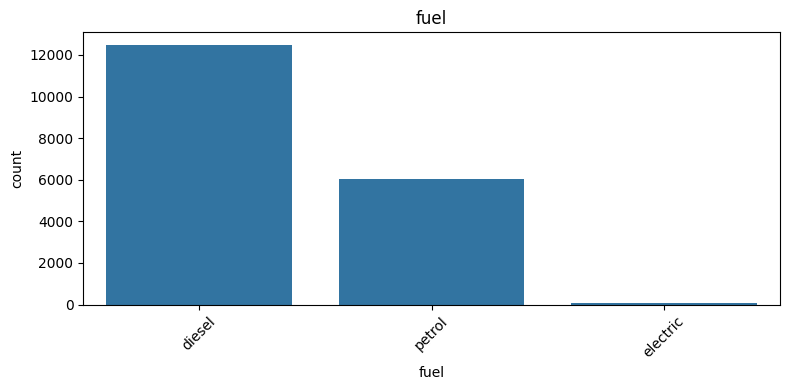

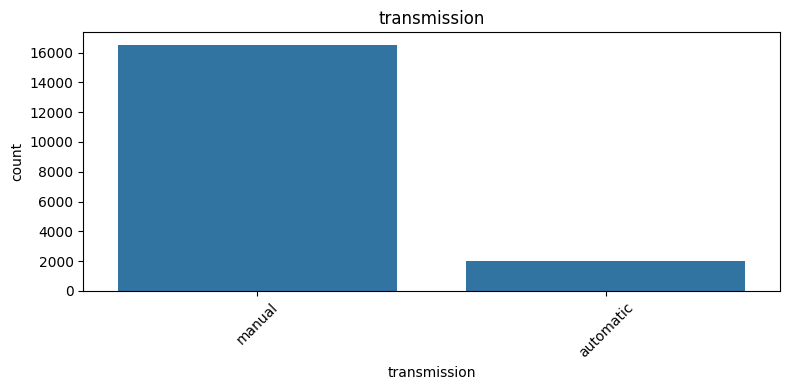

In [ ]:
cat_cols = ['colour','aestheticGrade','mechanicalGrade','make','model','type','fuel','transmission']
cat_cols = [c for c in cat_cols if c in df.columns]

for c in cat_cols:
    s = df[c].fillna("Unknown")
    plt.figure(figsize=(8, 4))
    sns.countplot(x=s, order=s.value_counts().head(10).index)
    plt.title(c)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## YData Profiling on cleaned data


In [ ]:
# ProfileReport(../data/clean_data.csv, title="EDA Car Prices", explorative=True)

## Summary of Findings


### Overview
- The data is already quite clean with < 0.1% missing cells and 0 duplicate rows.
- The data is small and fits in RAM; avoid dropping rows given the small n.
- The dataset has a healthy mix of data types.
- `vehicleID` is the primary key with all unique values.

### Alerts
- There are 9 high-correlation alerts; watch for multicollinearity.
- A few features are imbalanced, so underrepresentation may exist in the sample.

### Columns
- **registrationDate:** Proxy for car age; roughly centered around ~2011. Average age ≈ 14 years (assuming registration ≈ build time).
- **kilometers:** Heavily right-skewed with at least one extreme outlier. Remove outliers and log-transform to approximate normality.
- **colour:** Moderately high cardinality. Use model-based feature importance later to decide whether to keep.
- **aestheticGrade:** Low cardinality; likely a modest predictor.
- **mechanicalGrade:** Low cardinality; likely a modest predictor.
- **saleDate:** Correct dtype; useful as an index. Remove outliers.
- **make:** High cardinality; fine for trees, potentially problematic for linear models.
- **model:** High cardinality; fine for trees, likely problematic for linear models (consider binning or exclusion).
- **doorNumber:** Low cardinality; fine as is.
- **type:** Low cardinality; fine as is.
- **fuel:** Low cardinality with underrepresented Electric vehicles.
- **transmission:** Binary; map to 1/0. Automatic is underrepresented.
- **yearIntroduced:** May correlate strongly with age derived from `registrationDate`.
- **cylinder:** Clip outliers; impute or drop nulls.
- **cubeCapacity:** Treat 0 as null; impute with median.
- **powerKW / powerHP:** Likely collinear; drop one.
- **targetPrice:** Predict log(target); consider quantile models.


In [ ]:
df['saleDate'] = pd.to_datetime(df['saleDate'], errors='coerce')
df['registrationDate'] = pd.to_datetime(df['registrationDate'], errors='coerce')

yearintroduced_numeric = pd.to_numeric(df['yearIntroduced'], errors='coerce')
yearintroduced_date = pd.to_datetime(dict(year=yearintroduced_numeric, month=1, day=1), errors='coerce')

outliers = df[(df['saleDate'] < yearintroduced_date) | (df['registrationDate'] > df['saleDate'])]
outliers


/tmp/ipykernel_1146074/1609764388.py:2: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['registrationDate'] = pd.to_datetime(df['registrationDate'], errors='coerce')


,vehicleID,registrationDate,kilometers,colour,aestheticGrade,mechanicalGrade,saleDate,make,model,doorNumber,type,fuel,transmission,yearIntroduced,cylinder,cubeCapacity,powerKW,powerHP,targetPrice
25,v 12327,2019-11-23,35965,black,good,very good,1932-09-02,mercedes benz,classe c,4,sedan,diesel,automatic,2014,21,2143,125,170,30800
3693,v 1233695,2022-03-15,142037,grey,very good,very good,2022-03-12,opel,astra j,5,estate,diesel,manual,2010,16,1598,81,110,6400
5125,v 1235127,2022-08-06,105897,grey,good,very good,2022-07-11,mercedes benz,classe cla,5,estate,diesel,manual,2015,15,1461,80,109,17600
6874,v 1236876,2022-03-28,655,white,very good,very good,2022-01-11,seat,arona,5,hatchback,petrol,manual,2017,10,999,70,95,13800
6901,v 1236903,2022-02-28,96207,white,good,very good,2022-01-06,mercedes benz,classe cla,5,estate,diesel,automatic,2016,15,1461,80,109,21000
11297,v 12311299,2023-07-29,74957,white,good,very good,2023-05-12,renault,zoe,5,hatchback,electric,automatic,2013,0,0,68,92,8600
13524,v 12313526,2023-02-27,231062,blue,bad,good,2023-01-11,seat,leon,3,hatchback,diesel,manual,2013,20,1968,110,150,14100
18522,v 12318524,2023-04-14,54234,grey,good,good,2023-04-10,mercedes benz,classe c,5,estate,diesel,manual,2014,16,1598,85,116,17800


In [ ]:
#ProfileReport(../data/clean_data.csv, title="EDA Car Prices", explorative=True)